In [1]:
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons, TextBox # Matplotlib widgets
import matplotlib.pylab as plt # Plotting interface
import numpy as np
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, RazorThinExponentialDiskPotential, BurkertPotential # GALPY potentials
from galpy.potential import calcRotcurve # composed rotation curve calculation for plotting
from astropy import units # Physical/real units data managing
from astropy import table as Table # For fast and easy reading / writing with tables using numpy library
import corner
import time
import pandas as pd
import multiprocessing as mp
from scipy.optimize import fsolve


import ipywidgets as widgets


In [2]:

def boolString_to_bool(boolString):
    if boolString == 'True':
        return True
    elif boolString == 'False':
        return False
    else:
        return None

In [3]:
init_guess_params = Table.Table.read('../M33_guess_params.txt', format='ascii.tab')

In [4]:
init_guess_params

component,mass,a (kpc),b (kpc),checked
str12,float64,float64,float64,str5
BULGE,110000000.0,0.0,0.495,False
THIN DISC,38837296969.03567,10.069858729947157,2.499954901776149,True
THICK DISC,39000000000.0,2.6,0.8,False
EXP. DISC,500.0,5.3,0.0,False
DARK HALO,1196921394849.7383,18.682199726086495,0.0,True
BURKERT HALO,8000000.0,20.0,0.0,False


In [5]:
c_bulge, amp1, a1, b1, include_bulge = init_guess_params[0]
c_tn, amp2, a2, b2, include_tn = init_guess_params[1]
c_tk, amp3, a3, b3, include_tk = init_guess_params[2]
c_ex, amp4, h_r, vertical_ex, include_ex = init_guess_params[3]
c_dh, amp5, a5, b5, include_dh = init_guess_params[4]
c_bh, amp6, a6, b6, include_bh = init_guess_params[5]

In [6]:
visibility = [ boolString_to_bool(include_bulge), boolString_to_bool(include_tn), boolString_to_bool(include_tk), boolString_to_bool(include_ex), boolString_to_bool(include_dh), boolString_to_bool(include_bh)]

In [7]:
input_params=Table.Table.read('../input_params.txt', format='ascii.tab') # Initial parameters
input_params

FileNotFoundError: [Errno 2] No such file or directory: '../input_params.txt'

In [ ]:
tt=Table.Table.read('../M31_rot_curve.txt', format='ascii.tab') # Rotation curve

x_offset = 0.0  # It defines a radial coordinate offset as user input
r_0=1*units.kpc # units 
v_0=220*units.km/units.s # units 

# Real data:
r_data=tt['r']-x_offset # The txt file must contain the radial coordinate values in kpc
v_c_data=tt['vel'] # velocity in km/s
v_c_err_data = tt['e_vel'] # and velocity error in km/s

# This loop is needed since galpy fails when r=0 or very close to 0
for i in range(len(r_data)):
    if r_data[i]<1e-3:
        r_data[i]=1e-3



In [ ]:
tt

r,r2,vel,e_vel
float64,float64,float64,float64
25.0,5.68,235.5,17.8
30.0,6.81,242.9,0.8
35.0,7.95,251.1,0.7
40.0,9.08,262.0,2.1
45.0,10.22,258.9,6.9
50.0,11.35,255.1,5.7
55.0,12.49,251.8,17.1
60.0,13.62,252.1,7.4
65.0,14.76,251.0,18.6


In [ ]:
lista=np.linspace(0.001, 1.02*np.max(r_data), 10*len(r_data)) # radial coordinate for the rotation curve calculation
lista

array([1.00000000e-03, 5.60351254e-01, 1.11970251e+00, 1.67905376e+00,
       2.23840502e+00, 2.79775627e+00, 3.35710753e+00, 3.91645878e+00,
       4.47581004e+00, 5.03516129e+00, 5.59451254e+00, 6.15386380e+00,
       6.71321505e+00, 7.27256631e+00, 7.83191756e+00, 8.39126882e+00,
       8.95062007e+00, 9.50997133e+00, 1.00693226e+01, 1.06286738e+01,
       1.11880251e+01, 1.17473763e+01, 1.23067276e+01, 1.28660789e+01,
       1.34254301e+01, 1.39847814e+01, 1.45441326e+01, 1.51034839e+01,
       1.56628351e+01, 1.62221864e+01, 1.67815376e+01, 1.73408889e+01,
       1.79002401e+01, 1.84595914e+01, 1.90189427e+01, 1.95782939e+01,
       2.01376452e+01, 2.06969964e+01, 2.12563477e+01, 2.18156989e+01,
       2.23750502e+01, 2.29344014e+01, 2.34937527e+01, 2.40531039e+01,
       2.46124552e+01, 2.51718065e+01, 2.57311577e+01, 2.62905090e+01,
       2.68498602e+01, 2.74092115e+01, 2.79685627e+01, 2.85279140e+01,
       2.90872652e+01, 2.96466165e+01, 3.02059677e+01, 3.07653190e+01,
      

In [ ]:
class MiyamotoNagaiP:
    def __init__(self, dict_params):
        self.amp = dict_params['amp']
        self.a = dict_params['a']
        self.b = dict_params['b']
    
    def __str__(self):
        return f"amp={self.amp}, a={self.a}, b={self.b}"
    
    def __repr__(self):
        return f"amp={self.amp}, a={self.a}, b={self.b}"
        
class MassScaleP:
    def __init__(self, dict_params):
        self.amp = dict_params['amp']
        self.a = dict_params['a']
    
    def __str__(self):
        return f"amp={self.amp}, a={self.a}"
    
    def __repr__(self):
        return f"amp={self.amp}, a={self.a}"
        

In [ ]:
amp1 = widgets.FloatSlider(min=110000000.0*10**(-1), max=110000000.0*10**(1), step=110000000.0*0.1)
b1 = widgets.FloatSlider(min=0.495*(100-70)/100, max=0.495*(100+70)/100, step=0.495*0.1)
ui = widgets.HBox([amp1, b1])
def f(amp1, b1):
    global bulge_potential
    bulge_dict = {'amp': amp1, 'a':0, 'b': b1 }
    bulge_potential = MiyamotoNagaiP(bulge_dict)
    print((amp1, b1))
bulge_params = widgets.interactive_output(f, {'amp1': amp1, 'b1': b1})
display(ui, bulge_params)

Output()

In [ ]:
amp2 = widgets.FloatSlider(min=3900000000.0*10**(-1), max=3900000000.0*10**(1), step=3900000000.0*0.1)
a2 = widgets.FloatSlider(min=5.3*(100-90)/100, max=5.3*(100+90)/100, step=5.3*0.1)
b2 = widgets.FloatSlider(min=0.25*(100-90)/100, max=0.25*(100+90)/100, step=0.25*0.1)
ui = widgets.HBox([amp2, a2, b2])
def f(amp2, a2, b2):
    global thin_disk_potential
    thin_disk_dict = {'amp': amp2, 'a':a2, 'b': b2 }
    thin_disk_potential = MiyamotoNagaiP(thin_disk_dict)
    print((amp2, a2, b2))

thin_disk_params = widgets.interactive_output(f, {'amp2': amp2, 'a2': a2, 'b2': b2})

display(ui, thin_disk_params)



Output()

In [ ]:
amp3 = widgets.FloatSlider(min=39000000000.0*10**(-0.5), max=39000000000.0*10**(0.5), step=39000000000.0*0.1)
a3 = widgets.FloatSlider(min=2.6*(100-20)/100, max=2.6*(100+20)/100, step=2.6*0.1)
b3 = widgets.FloatSlider(min=0.8*(100-90)/100, max=0.8*(100+90)/100, step=0.8*0.1)
ui = widgets.HBox([amp3, a3, b3])
def f(amp3, a3, b3):
    global thick_disk_potential
    thick_disk_dict = {'amp': amp3, 'a':a3, 'b': b3 }
    thick_disk_potential = MiyamotoNagaiP(thick_disk_dict)
    print((amp3, a3, b3))

thick_disk_params = widgets.interactive_output(f, {'amp3': amp3, 'a3': a3, 'b3': b3})

display(ui, thin_disk_params)


Output(outputs=({'name': 'stdout', 'text': '(390000000.0, 0.53, 0.025)\n', 'output_type': 'stream'},))

In [ ]:
amp4 = widgets.FloatSlider(min=500.0*10**(-0.5), max=500.0*10**(0.5), step=500.0*0.1)
h_r = widgets.FloatSlider(min=5.3*(100-90)/100, max=5.3*(100+90)/100, step=5.3*0.1)
ui = widgets.HBox([amp4, h_r ])
def f(amp4, h_r):
    global exp_disk_potential
    exp_disk_dict = {'amp': amp4, 'a': h_r}
    exp_disk_potential = MassScaleP(exp_disk_dict)
    print((amp4, h_r))
exp_disk_params = widgets.interactive_output(f, {'amp4': amp4, 'h_r': h_r})
display(ui, exp_disk_params)

Output()

In [ ]:
amp5 = widgets.FloatSlider(min=140000000000.0*10**(-1), max=140000000000.0*10**(1), step=140000000000.0*0.1)
a5 = widgets.FloatSlider(min=13*(100-90)/100, max=13*(100+90)/100, step=13*0.1)
ui = widgets.HBox([amp5, a5 ])
def f(amp5, a5):
    global dark_halo_potential
    dark_halo_dict = {'amp': amp5, 'a': a5}
    dark_halo_potential = MassScaleP(dark_halo_dict)
    print((amp5, a5))
dark_halo_params = widgets.interactive_output(f, {'amp5': amp5, 'a5': a5})
display(ui, dark_halo_params)

Output()

In [ ]:
amp6 = widgets.FloatSlider(min=8000000.0*10**(-1), max=8000000.0*10**(1), step=8000000.0*0.1)
a6 = widgets.FloatSlider(min=20*(100-90)/100, max=20*(100+90)/100, step=20*0.1)
ui = widgets.HBox([amp6, a6 ])
def f(amp6, a6):
    global burkert_halo_potential
    burkert_halo_dict = {'amp': amp6, 'a': a6}
    burkert_halo_potential = MassScaleP(burkert_halo_dict)
    print((amp6, a6))
burkert_halo_params = widgets.interactive_output(f, {'amp6': amp6, 'a6': a6})
display(ui, burkert_halo_params)

Output()

In [ ]:
lista=np.linspace(0.001, 1.02*np.max(r_data), 10*len(r_data))

In [ ]:
bulge_potential, thin_disk_potential, thick_disk_potential, exp_disk_potential, dark_halo_potential, burkert_halo_potential

(amp=11000000.0, a=0, b=0.1485,
 amp=390000000.0, a=0.53, b=0.025,
 amp=12332882874.65668, a=2.08, b=0.08,
 amp=158.11388300841898, a=0.53,
 amp=14000000000.0, a=1.3,
 amp=800000.0, a=2.0)

In [ ]:
data_rows = [('BULGE', 110000000.0, 1.0, 0.0, 20, 0.495, 70),
             ('THIN DISK', 3900000000.0, 1.0, 5.3, 90, 0.25, 1),
             ('THICK DISK', 39000000000.0, 0.5, 2.6, 20, 0.8, 1),
             ('EXP DISK', 500.0, 0.5, 5.3, 90, 0.0, 0),
             ('DARK HALO', 140000000000.0, 1.0, 13.0, 90, 0.0, 0),
             ('BURKERT HALO', 8000000.0, 1.0, 20.0, 90, 0.0, 0)]
input_params = Table.Table(rows=data_rows, names=('component', 'mass', 'threshold_mass', 'a (kpc)', 'threshold_a', 'b (kpc)', 'threshold_b'))

def input_component(component, guess_mass, guess_a, guess_b):
    
    component_mass, component_scale_a, component_scale_b = guess_mass, guess_a, guess_b
    
    print('Set the guess parameters for', component)
    try:
        component_mass = float(input('Mass (in M_sun):'))
    except:
        print('No valid Mass for', component, '. It will be taken the default mass:', component_mass, 'M_sun')
    
    
    try:
        component_scale_a = float(input('Radial Scale Length (in kpc):'))
    except:
        print('No valid Radial Scale Length for', component, '. It will be taken the default Radial Scale Lenght:', component_scale_a, 'kpc')

    if component not in ['EXP DISK', 'DARK HALO', 'BURKERT HALO' ]:
        try:
            component_scale_b = float(input('Vertical Scale Length (in kpc):'))
        except:
            print('No valid Vertical Scale Length for', component, '. It will be taken the default Vertical Scale Lenght:', component_scale_b, 'kpc')
    
    return component_mass, component_scale_a, component_scale_b

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

x_offset = 0.0  # It defines a radial coordinate offset as user input
r_0=1*units.kpc # units 
v_0=220*units.km/units.s # units 

# Real data:
r_data=tt['r']-x_offset # The txt file must contain the radial coordinate values in kpc
v_c_data=tt['vel'] # velocity in km/s
v_c_err_data = tt['e_vel'] # and velocity error in km/s

# This loop is needed since galpy fails when r=0 or very close to 0
for i in range(len(r_data)):
    if r_data[i]<1e-3:
        r_data[i]=1e-3

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Initial parameters:

c_bulge, amp1, delta_mass_bulge, a1, delta_radial_bulge, b1, delta_vertical_bulge = input_params[0]
amp1, a1, b1 = input_component(c_bulge, amp1, a1, b1)
#print(mass, radial, vertical)

c_tn, amp2, delta_mass_tn, a2, delta_radial_tn, b2, delta_vertical_tn = input_params[1]
amp2, a2, b2 = input_component(c_tn, amp2, a2, b2)
#print(mass, radial, vertical)

c_tk, amp3, delta_mass_tk, a3, delta_radial_tk, b3, delta_vertical_tk = input_params[2]
amp3, a3, b3 = input_component(c_tk, amp3, a3, b3)
#print(mass, radial, vertical)

c_ex, amp4, delta_mass_ex, h_r, delta_radial_ex, vertical_ex, delta_vertical_ex = input_params[3]
amp4, h_r, vertical_ex = input_component(c_ex, amp4, h_r, vertical_ex)
#print(mass, radial, vertical)

c_dh, amp5, delta_mass_dh, a5, delta_radial_dh, b5, delta_vertical_dh = input_params[4]
amp5, a5, b5 = input_component(c_dh, amp5, a5, b5)
#print(mass, radial, vertical)

c_bh, amp6, delta_mass_bh, a6, delta_radial_bh, b6, delta_vertical_bh = input_params[5]
amp6, a6, b6 = input_component(c_bh, amp6, a6, b6)

Set the guess parameters for BULGE
No valid Mass for BULGE . It will be taken the default mass: 110000000.0 M_sun
No valid Radial Scale Length for BULGE . It will be taken the default Radial Scale Lenght: 0.0 kpc
No valid Vertical Scale Length for BULGE . It will be taken the default Vertical Scale Lenght: 0.495 kpc
Set the guess parameters for THIN DISK
No valid Mass for THIN DISK . It will be taken the default mass: 3900000000.0 M_sun
No valid Radial Scale Length for THIN DISK . It will be taken the default Radial Scale Lenght: 5.3 kpc
No valid Vertical Scale Length for THIN DISK . It will be taken the default Vertical Scale Lenght: 0.25 kpc
Set the guess parameters for THICK DISK
No valid Mass for THICK DISK . It will be taken the default mass: 39000000000.0 M_sun
No valid Radial Scale Length for THICK DISK . It will be taken the default Radial Scale Lenght: 2.6 kpc
No valid Vertical Scale Length for THICK DISK . It will be taken the default Vertical Scale Lenght: 0.8 kpc
Set the gu

In [ ]:
MN_Bulge_p= MiyamotoNagaiPotential(amp=bulge_potential.amp*units.Msun,
                                   a=bulge_potential.a*units.kpc,
                                   b=bulge_potential.b*units.kpc,
                                   normalize=False,
                                   ro=r_0, vo=v_0)
MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=thin_disk_potential.amp*units.Msun,
                                       a=thin_disk_potential.a*units.kpc,
                                       b=thin_disk_potential.b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=thick_disk_potential.amp*units.Msun,
                                        a=thick_disk_potential.a*units.kpc,
                                        b=thick_disk_potential.b*units.kpc,
                                        normalize=False,
                                        ro=r_0, vo=v_0)
EX_Disk_p = RazorThinExponentialDiskPotential(amp=exp_disk_potential.amp*(units.Msun/(units.pc**2)), 
                                              hr=exp_disk_potential.a*units.kpc, 
                                              normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
NFW_p = NFWPotential(amp=dark_halo_potential.amp*units.Msun, 
                     a=dark_halo_potential.a*units.kpc, normalize=False, ro=r_0, vo=v_0)
BK_p = BurkertPotential(amp=burkert_halo_potential.amp*units.Msun/(units.kpc)**3, 
                        a=burkert_halo_potential.a*units.kpc, normalize=False, ro=r_0, vo=v_0)

# Circular velocities in km/s
MN_Bulge = calcRotcurve(MN_Bulge_p, lista, phi=None)*220
MN_Thin_Disk = calcRotcurve(MN_Thin_Disk_p, lista, phi=None)*220
MN_Thick_Disk = calcRotcurve(MN_Thick_Disk_p, lista, phi=None)*220
EX_Disk = calcRotcurve(EX_Disk_p, lista, phi=None)*220
NFW = calcRotcurve(NFW_p, lista, phi=None)*220
BK = calcRotcurve(BK_p, lista, phi=None)*220

# Circular velocity for the composition of 5 potentials in km/s
v_circ_comp = calcRotcurve([MN_Bulge_p,MN_Thin_Disk_p,MN_Thick_Disk_p, EX_Disk_p, NFW_p, BK_p], lista, phi=None)*220



In [ ]:
bulge_potential

amp=11000000.0, a=0, b=0.1485

In [ ]:
c_bulge, amp1, delta_mass_bulge, a1, delta_radial_bulge, b1, delta_vertical_bulge 

('BULGE', 110000000.0, 1.0, 0.0, 20, 0.495, 70)

In [ ]:
c_dh, amp5, delta_mass_dh, a5, delta_radial_dh, b5, delta_vertical_dh 

('DARK HALO', 140000000000.0, 1.0, 13.0, 90, 0.0, 0)

In [ ]:
from scipy.optimize import curve_fit

# Bulge_NFW_potentials

In [ ]:
def Bulge_NFW_potentials( r, delta_r, bulge_amp, bulge_a, bulge_b, dark_halo_amp, dark_halo_a ):
    r_0=1*units.kpc # units 
    v_0=220*units.km/units.s # units 

    MN_Bulge_p= MiyamotoNagaiPotential(amp=bulge_amp*units.Msun,
                                       a=bulge_a*units.kpc,
                                       b=bulge_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    NFW_p = NFWPotential(amp=dark_halo_amp*units.Msun, 
                         a=dark_halo_a*units.kpc, 
                         normalize=False, 
                         ro=r_0, vo=v_0)

    v_circ_comp = calcRotcurve([MN_Bulge_p, NFW_p], r-delta_r , phi=None)*220
    return v_circ_comp



bounds = (( -10, amp1/(10**delta_mass_bulge), a1, b1*(1-0.01*delta_vertical_bulge), amp5/(10*delta_mass_dh), a5*(1-0.01*delta_radial_dh)  ), 
          (  10, amp1*(10**delta_mass_bulge), 0.1*delta_radial_bulge,  b1*(1+0.01*delta_vertical_bulge), amp5*(10**delta_mass_dh), a5*(1+0.01*delta_radial_dh)  ) )

bounds

((-10,
  11000000.0,
  0.0,
  0.14849999999999997,
  14000000000.0,
  1.2999999999999998),
 (10, 1100000000.0, 2.0, 0.8415, 1400000000000.0, 24.7))

[5.96212202e+00 1.10000000e+07 2.00000000e+00 8.41500000e-01
 1.19139516e+12 1.75709355e+01] [8.76101130e+02 9.58848487e+12 2.63861065e+06 1.40609543e+06
 4.72477370e+12 3.65459561e+02]


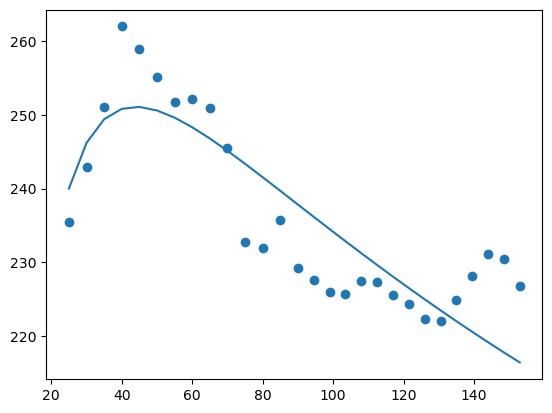

In [ ]:
popt, pcov = curve_fit(Bulge_NFW_potentials, 
                       r_data, v_c_data.data, 
                       p0=[0, amp1, a1, b1, amp5, a5 ],
                       bounds=bounds )

print(popt, np.sqrt(np.diag(pcov)))

plt.scatter( r_data, v_c_data.data )
plt.plot( r_data, Bulge_NFW_potentials( r_data, *popt ) )

# Bulge_ThinDisk_NFW_potentials

In [ ]:
c_tn, amp2, delta_mass_tn, a2, delta_radial_tn, b2, delta_vertical_tn 

('THIN DISK', 3900000000.0, 1.0, 5.3, 90, 0.25, 1)

In [ ]:
def Bulge_ThinDisk_NFW_potentials( r, delta_r, bulge_amp, bulge_a, bulge_b, tn_amp, tn_a, tn_b, dark_halo_amp, dark_halo_a ):
    r_0=1*units.kpc # units 
    v_0=220*units.km/units.s # units 

    MN_Bulge_p= MiyamotoNagaiPotential(amp=bulge_amp*units.Msun,
                                       a=bulge_a*units.kpc,
                                       b=bulge_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=tn_amp*units.Msun,
                                       a=tn_a*units.kpc,
                                       b=tn_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    NFW_p = NFWPotential(amp=dark_halo_amp*units.Msun, 
                         a=dark_halo_a*units.kpc, 
                         normalize=False, 
                         ro=r_0, vo=v_0)

    v_circ_comp = calcRotcurve([MN_Bulge_p, MN_Thin_Disk_p, NFW_p], r-delta_r , phi=None)*220
    return v_circ_comp



bounds = (( -10, amp1/(10**delta_mass_bulge), a1, b1*(1-0.01*delta_vertical_bulge), amp2/(10**delta_mass_tn), a2*(1-0.01*delta_radial_tn), b2/(10**delta_vertical_tn), amp5/(10*delta_mass_dh), a5*(1-0.01*delta_radial_dh)  ), 
          (  10, amp1*(10**delta_mass_bulge), 0.1*delta_radial_bulge,  b1*(1+0.01*delta_vertical_bulge), amp2*(10**delta_mass_tn), a2*(1+0.01*delta_radial_tn), b2*(10**delta_vertical_tn), amp5*(10**delta_mass_dh), a5*(1+0.01*delta_radial_dh)  ) )

bounds

((-10,
  11000000.0,
  0.0,
  0.14849999999999997,
  390000000.0,
  0.5299999999999999,
  0.025,
  14000000000.0,
  1.2999999999999998),
 (10,
  1100000000.0,
  2.0,
  0.8415,
  39000000000.0,
  10.069999999999999,
  2.5,
  1400000000000.0,
  24.7))

[7.53306450e+00 1.10000000e+09 2.00000000e+00 8.41500000e-01
 3.90000000e+10 1.00700000e+01 2.50000000e+00 1.21045788e+12
 1.89625108e+01] [3.07158955e+03 2.44250797e+12 1.21102479e+06 1.12020004e+06
 1.86413180e+13 3.17103392e+06 3.16954522e+06 1.27145355e+13
 1.01752935e+03]


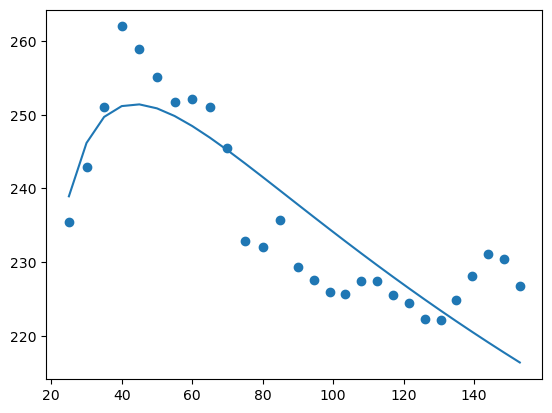

In [ ]:
popt, pcov = curve_fit(Bulge_ThinDisk_NFW_potentials, 
                       r_data, v_c_data.data, 
                       p0=[0, amp1, a1, b1, amp2, a2, b2, amp5, a5 ],
                       bounds=bounds )

print(popt, np.sqrt(np.diag(pcov)))

plt.scatter( r_data, v_c_data.data )
plt.plot( r_data, Bulge_ThinDisk_NFW_potentials( r_data, *popt ) )

# ThinDisk_NFW_potentials

In [ ]:
def ThinDisk_NFW_potentials( r, delta_r, tn_amp, tn_a, tn_b, dark_halo_amp, dark_halo_a ):
    r_0=1*units.kpc # units 
    v_0=220*units.km/units.s # units 

    MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=tn_amp*units.Msun,
                                       a=tn_a*units.kpc,
                                       b=tn_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    NFW_p = NFWPotential(amp=dark_halo_amp*units.Msun, 
                         a=dark_halo_a*units.kpc, 
                         normalize=False, 
                         ro=r_0, vo=v_0)

    v_circ_comp = calcRotcurve([ MN_Thin_Disk_p, NFW_p], r-delta_r , phi=None)*220
    return v_circ_comp



bounds = (( -10, amp2/(10**delta_mass_tn), a2*(1-0.01*delta_radial_tn), b2/(10**delta_vertical_tn), amp5/(10*delta_mass_dh), a5*(1-0.01*delta_radial_dh)  ), 
          (  10, amp2*(10**delta_mass_tn), a2*(1+0.01*delta_radial_tn), b2*(10**delta_vertical_tn), amp5*(10**delta_mass_dh), a5*(1+0.01*delta_radial_dh)  ) )

bounds

((-10,
  390000000.0,
  0.5299999999999999,
  0.025,
  14000000000.0,
  1.2999999999999998),
 (10, 39000000000.0, 10.069999999999999, 2.5, 1400000000000.0, 24.7))

[7.89525604e+00 3.88373055e+10 1.00698588e+01 2.49995484e+00
 1.19692206e+12 1.86822117e+01] [9.65163129e+01 4.98821546e+11 2.40230624e+06 2.40231621e+06
 4.53242672e+11 1.75133468e+01]


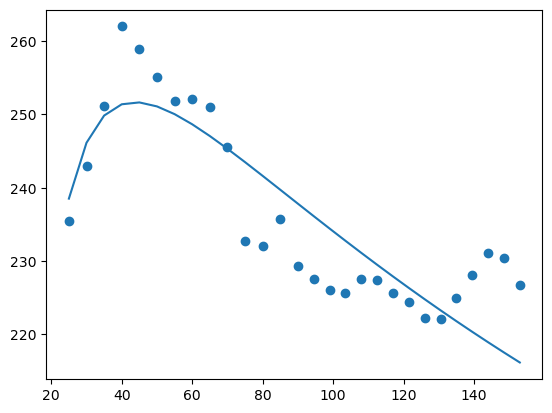

In [ ]:
popt, pcov = curve_fit(ThinDisk_NFW_potentials, 
                       r_data, v_c_data.data, 
                       p0=[0,  amp2, a2, b2, amp5, a5 ],
                       bounds=bounds )

print(popt, np.sqrt(np.diag(pcov)))

plt.scatter( r_data, v_c_data.data )
plt.plot( r_data, ThinDisk_NFW_potentials( r_data, *popt ) )

In [ ]:
run args_input.py a b

a
Creation of the directory a failed


In [ ]:
args = [1, 2, 3]
flag = True
for i in args:
    if i not in [1, 2, 4, 5]:
        flag = False

In [ ]:
flag

False

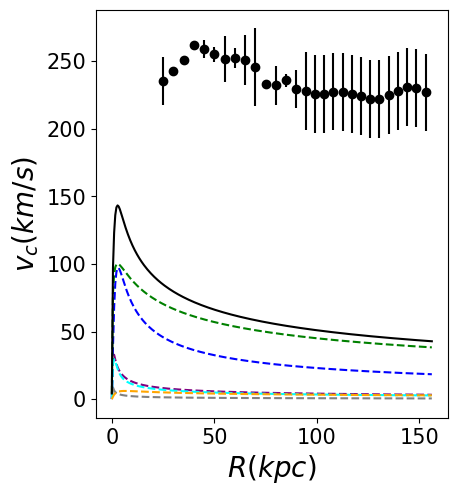

In [ ]:

fig = plt.figure(1)
ax = fig.add_axes((0.41, 0.1, 0.55, 0.85))

#ax.yaxis.set_ticks_position('both')
#ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)

# Data
CV_galaxy = ax.errorbar(r_data, v_c_data, v_c_err_data,  c='k', fmt='', ls='none')
CV_galaxy_dot = ax.scatter(r_data, v_c_data, c='k')

# A plot for each rotation curve with the colors indicated below
MN_b_plot, = ax.plot(lista, MN_Bulge, linestyle='--', c='gray')
MN_td_plot, = ax.plot(lista, MN_Thin_Disk, linestyle='--', c='purple')
MN_tkd_plot, = ax.plot(lista, MN_Thick_Disk, linestyle='--', c='blue')
EX_d_plot, = ax.plot(lista, EX_Disk, linestyle='--', c='cyan')
NFW_plot, = ax.plot(lista, NFW, linestyle='--', c='green')
BK_plot, = ax.plot(lista, BK, linestyle='--', c='orange')

# Composed rotation curve
v_circ_comp_plot, = ax.plot(lista, v_circ_comp, c='k')


ax.set_xlabel(r'$R(kpc)$', fontsize=20)
ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=15)

C:\Users\Abram\AppData\Local\Temp\ipykernel_21596\1700101123.py:4: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  for r in check.rectangles: # Checkbox options-colors

C:\Users\Abram\AppData\Local\Temp\ipykernel_21596\1700101123.py:9: MatplotlibDeprecationWarning: The lines attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  [ll.set_color("black") for l in check.lines for ll in l]

C:\Users\Abram\AppData\Local\Temp\ipykernel_21596\1700101123.py:10: MatplotlibDeprecationWarning: The lines attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  [ll.set_linewidth(2) for l in check.lines for ll in l]



[None, None, None, None, None, None, None, None, None, None, None, None]

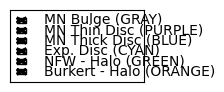

In [ ]:
rax = plt.axes((0.07, 0.8, 0.21, 0.15))
check = CheckButtons(rax, ('MN Bulge (GRAY)', 'MN Thin Disc (PURPLE)', 'MN Thick Disc (BLUE)', 'Exp. Disc (CYAN)', 'NFW - Halo (GREEN)', 'Burkert - Halo (ORANGE)'), (True, True, True, True, True, True))

for r in check.rectangles: # Checkbox options-colors
    r.set_facecolor("lavender") 
    r.set_edgecolor("black")
    #r.set_alpha(0.2) 

[ll.set_color("black") for l in check.lines for ll in l]
[ll.set_linewidth(2) for l in check.lines for ll in l]


In [ ]:
MN_b_amp_ax = fig.add_axes((0.09,0.75,0.17,0.03))
MN_b_amp_s = Slider(MN_b_amp_ax, r"$M$($M_\odot$)", input_params['mass'][0]/(10**input_params['threshold_mass'][0]), input_params['mass'][0]*(10**input_params['threshold_mass'][0]), valinit=input_params['mass'][0], color='gray', valfmt='%1.3E')
MN_b_a_ax = fig.add_axes((0.09,0.72,0.17,0.03))
MN_b_a_s = Slider(MN_b_a_ax, "$a$ ($kpc$)", 0, 0.1*input_params['threshold_a'][0], valinit=input_params['a (kpc)'][0], color='gray')
MN_b_b_ax = fig.add_axes((0.09,0.69,0.17,0.03))
MN_b_b_s = Slider(MN_b_b_ax, "$b$ ($kpc$)", input_params['b (kpc)'][0]*(1-0.01*input_params['threshold_b'][0]), input_params['b (kpc)'][0]*(1+0.01*input_params['threshold_b'][0]), valinit=input_params['b (kpc)'][0], color='gray')

# Thin disk - purple
MN_td_amp_ax = fig.add_axes((0.09,0.63,0.17,0.03))
MN_td_amp_s = Slider(MN_td_amp_ax, r"$M$($M_\odot$)", input_params['mass'][1]/(10**input_params['threshold_mass'][1]), input_params['mass'][1]*(10**input_params['threshold_mass'][1]), valinit=input_params['mass'][1], color='purple', valfmt='%1.3E')
MN_td_a_ax = fig.add_axes((0.09,0.60,0.17,0.03))
MN_td_a_s = Slider(MN_td_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][1]*(1-0.01*input_params['threshold_a'][1]), input_params['a (kpc)'][1]*(1+0.01*input_params['threshold_a'][1]), valinit=input_params['a (kpc)'][1], color='purple')
MN_td_b_ax = fig.add_axes((0.09,0.57,0.17,0.03))
MN_td_b_s = Slider(MN_td_b_ax, "$b$ ($kpc$)", input_params['b (kpc)'][1]/(10**input_params['threshold_b'][1]), input_params['b (kpc)'][1]*(10**input_params['threshold_b'][1]), valinit=input_params['b (kpc)'][1], color='purple')

# Thick disk - Blue
MN_tkd_amp_ax = fig.add_axes((0.09,0.51,0.17,0.03))
MN_tkd_amp_s = Slider(MN_tkd_amp_ax, r"$M$($M_\odot$)", input_params['mass'][2]/(10**input_params['threshold_mass'][2]), input_params['mass'][2]*(10**input_params['threshold_mass'][2]), valinit=input_params['mass'][2], color='blue', valfmt='%1.3E')
MN_tkd_a_ax = fig.add_axes((0.09,0.48,0.17,0.03))
MN_tkd_a_s = Slider(MN_tkd_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][2]*(1-0.01*input_params['threshold_a'][2]), input_params['a (kpc)'][2]*(1+0.01*input_params['threshold_a'][2]), valinit=input_params['a (kpc)'][2], color='blue')
MN_tkd_b_ax = fig.add_axes((0.09,0.45,0.17,0.03))
MN_tkd_b_s = Slider(MN_tkd_b_ax, "$b$ ($kpc$)", input_params['b (kpc)'][2]/(10**input_params['threshold_b'][2]), input_params['b (kpc)'][2]*(10**input_params['threshold_b'][2]), valinit=input_params['b (kpc)'][2], color='blue')

# Exponential disk - Cyan
MN_ed_amp_ax = fig.add_axes((0.09,0.39,0.17,0.03))
MN_ed_amp_s = Slider(MN_ed_amp_ax, r"$\Sigma_0$($M_\odot/pc^2$)", input_params['mass'][3]/(10**input_params['threshold_mass'][3]), input_params['mass'][3]*(10**input_params['threshold_mass'][3]), valinit=input_params['mass'][3], color='cyan', valfmt='%1.3E')
MN_ed_a_ax = fig.add_axes((0.09,0.36,0.17,0.03))
MN_ed_a_s = Slider(MN_ed_a_ax, "$h_r$ ($kpc$)", input_params['a (kpc)'][3]*(1-0.01*input_params['threshold_a'][3]), input_params['a (kpc)'][3]*(1+0.01*input_params['threshold_a'][3]), valinit=input_params['a (kpc)'][3], color='cyan')

# NFW Halo - green
NFW_amp_ax = fig.add_axes((0.09,0.30,0.17,0.03))
NFW_amp_s = Slider(NFW_amp_ax, r"$M_0$($M_\odot$)", input_params['mass'][4]/(10*input_params['threshold_mass'][4]), input_params['mass'][4]*(10**input_params['threshold_mass'][4]), valinit=input_params['mass'][4], color='green', valfmt='%1.3E')
NFW_a_ax = fig.add_axes((0.09,0.27,0.17,0.03))
NFW_a_s = Slider(NFW_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][4]*(1-0.01*input_params['threshold_a'][4]), input_params['a (kpc)'][4]*(1+0.01*input_params['threshold_a'][4]), valinit=input_params['a (kpc)'][4], color='green')

# Burkert Halo - orange
BK_amp_ax = fig.add_axes((0.09,0.21,0.17,0.03))
BK_amp_s = Slider(BK_amp_ax, r"$\rho_0$($M_\odot/kpc^3$)", input_params['mass'][5]/(10*input_params['threshold_mass'][5]), input_params['mass'][5]*(10**input_params['threshold_mass'][5]), valinit=input_params['mass'][5], color='orange', valfmt='%1.3E')
BK_a_ax = fig.add_axes((0.09,0.18,0.17,0.03))
BK_a_s = Slider(BK_a_ax, "$a$ ($kpc$)", input_params['a (kpc)'][5]*(1-0.01*input_params['threshold_a'][5]), input_params['a (kpc)'][5]*(1+0.01*input_params['threshold_a'][5]), valinit=input_params['a (kpc)'][5], color='orange')


In [ ]:

# Bulge
def MN_b_amp_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        amp1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=val*units.Msun,a=a1*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)   
        update_rot_curve()
def MN_b_a_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        a1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=amp1*units.Msun,a=val*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)   
        update_rot_curve()
def MN_b_b_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        b1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=amp1*units.Msun,a=a1*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)   
        update_rot_curve()
        
# Thin disk
def MN_td_amp_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        amp2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=val*units.Msun,a=a2*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_td_a_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        a2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=val*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_td_b_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        b2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=a2*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()

# Thick disk
def MN_tkd_amp_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        amp3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=val*units.Msun,a=a3*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_tkd_a_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        a3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=val*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
def MN_tkd_b_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        b3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=a3*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)  
        update_rot_curve()
        
# Exponential disk
def MN_ed_amp_s_func(val):
    if EX_d_plot.get_visible() == True:
        global EX_Disk_p, amp4,h_r
        amp4=val*1
        EX_Disk_p = RazorThinExponentialDiskPotential(amp=val*(units.Msun/(units.pc**2)), hr=h_r*units.kpc, maxiter=20, tol=0.001, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
        update_rot_curve() 
def MN_ed_a_s_func(val):
    if EX_d_plot.get_visible() == True:
        global EX_Disk_p, amp4,h_r
        h_r=val*1
        EX_Disk_p = RazorThinExponentialDiskPotential(amp=amp4*(units.Msun/(units.pc**2)), hr=val*units.kpc, maxiter=20, tol=0.001, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
        update_rot_curve()
        
# NFW Halo       
def NFW_amp_s_func(val):
    if NFW_plot.get_visible() == True:
        global NFW_p, amp5,a5
        amp5=val*1
        NFW_p = NFWPotential(amp=val*units.Msun, a=a5*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()    
def NFW_a_s_func(val):
    if NFW_plot.get_visible() == True:
        global NFW_p, amp5,a5
        a5=val*1
        NFW_p = NFWPotential(amp=amp5*units.Msun, a=val*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()

# Burkert Halo        
def BK_amp_s_func(val):
    if BK_plot.get_visible() == True:
        global BK_p, amp6,a6
        amp6=val*1
        BK_p = BurkertPotential(amp=val*units.Msun/(units.kpc)**3, a=a6*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()
def BK_a_s_func(val):
    if BK_plot.get_visible() == True:
        global BK_p, amp6,a6
        a6=val*1
        BK_p = BurkertPotential(amp=amp6*units.Msun/(units.kpc)**3, a=val*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()

In [ ]:
def update_rot_curve():
	ax.clear()
	global MN_b_plot, MN_Bulge_p, MN_Thin_Disk_p,MN_Thick_Disk_p, MN_td_plot,MN_tkd_plot, NFW_p, NFW_plot, EX_d_plot, EX_Disk_p, CV_galaxy, CV_galaxy_dot, BK_p, BK_plot
	composite_pot_array=[]
	ax.set_xlabel(r'$R(kpc)$', fontsize=20)
	ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
	ax.tick_params(axis='both', which='both', labelsize=15)
	#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
	ax.set_xlim([0, 1.02*r_data[-1]])
	ax.set_ylim([0,np.max(v_c_data)*1.2])
    
	if MN_b_plot.get_visible() == True:
		MN_Bulge = calcRotcurve(MN_Bulge_p, lista, phi=None)*220
		MN_b_plot, = ax.plot(lista, MN_Bulge, linestyle='--', c='gray')
		composite_pot_array.append(MN_Bulge_p)
	if MN_td_plot.get_visible() == True:
		MN_Thin_Disk = calcRotcurve(MN_Thin_Disk_p, lista, phi=None)*220
		MN_td_plot, = ax.plot(lista, MN_Thin_Disk, linestyle='--', c='purple')
		composite_pot_array.append(MN_Thin_Disk_p)
	if MN_tkd_plot.get_visible() == True:
		MN_Thick_Disk = calcRotcurve(MN_Thick_Disk_p, lista, phi=None)*220
		MN_tkd_plot, = ax.plot(lista, MN_Thick_Disk, linestyle='--', c='blue')
		composite_pot_array.append(MN_Thick_Disk_p)
	if NFW_plot.get_visible() == True:
		NFW = calcRotcurve(NFW_p, lista, phi=None)*220
		NFW_plot, = ax.plot(lista, NFW, linestyle='--', c='green')
		composite_pot_array.append(NFW_p)
	if EX_d_plot.get_visible() == True:
		EX_Disk = calcRotcurve(EX_Disk_p, lista, phi=None)*220
		EX_d_plot, = ax.plot(lista, EX_Disk, linestyle='--', c='cyan')
		composite_pot_array.append(EX_Disk_p)
	if BK_plot.get_visible() == True:
		BK = calcRotcurve(BK_p, lista, phi=None)*220
		BK_plot, = ax.plot(lista, BK, linestyle='--', c='orange')
		composite_pot_array.append(BK_p)
	CV_galaxy = ax.errorbar(r_data, v_c_data, v_c_err_data,  c='k', fmt='', ls='none')
	CV_galaxy_dot = ax.scatter(r_data, v_c_data, c='k')
	v_circ_comp = calcRotcurve(composite_pot_array, lista, phi=None)*220
	v_circ_comp_plot, = ax.plot(lista, v_circ_comp, c='k')


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the sliders update functions
MN_b_amp_s.on_changed(MN_b_amp_s_func)
MN_b_a_s.on_changed(MN_b_a_s_func)
MN_b_b_s.on_changed(MN_b_b_s_func)
MN_td_amp_s.on_changed(MN_td_amp_s_func)
MN_td_a_s.on_changed(MN_td_a_s_func)
MN_td_b_s.on_changed(MN_td_b_s_func)
MN_tkd_amp_s.on_changed(MN_tkd_amp_s_func)
MN_tkd_a_s.on_changed(MN_tkd_a_s_func)
MN_tkd_b_s.on_changed(MN_tkd_b_s_func)
NFW_amp_s.on_changed(NFW_amp_s_func)
NFW_a_s.on_changed(NFW_a_s_func)
BK_amp_s.on_changed(BK_amp_s_func)
BK_a_s.on_changed(BK_a_s_func)
MN_ed_amp_s.on_changed(MN_ed_amp_s_func)
MN_ed_a_s.on_changed(MN_ed_a_s_func)

0

In [ ]:
def reset(event):
    MN_b_amp_s.reset()
    MN_b_a_s.reset()
    MN_b_b_s.reset()
    MN_td_amp_s.reset()
    MN_td_a_s.reset() 
    MN_td_b_s.reset()
    MN_tkd_amp_s.reset()
    MN_tkd_a_s.reset()
    MN_tkd_b_s.reset()
    MN_ed_amp_s.reset()
    MN_ed_a_s.reset()
    NFW_amp_s.reset()
    NFW_a_s.reset()
    BK_amp_s.reset()
    BK_a_s.reset()

axcolor="lavender"
resetax = fig.add_axes((0.07, 0.08, 0.08, 0.05))
button_reset = Button(resetax, 'Reset', color=axcolor)
button_reset.on_clicked(reset)

0

In [ ]:
def check_on_clicked(label):

    if label == 'MN Bulge (GRAY)':
        MN_b_plot.set_visible(not MN_b_plot.get_visible())
        update_rot_curve()
    elif label == 'MN Thin Disc (PURPLE)':
        MN_td_plot.set_visible(not MN_td_plot.get_visible())
        update_rot_curve()
    elif label == 'MN Thick Disc (BLUE)':
        MN_tkd_plot.set_visible(not MN_tkd_plot.get_visible())
        update_rot_curve()
    elif label == 'Exp. Disc (CYAN)':
        EX_d_plot.set_visible(not EX_d_plot.get_visible())
        update_rot_curve()
    elif label == 'NFW - Halo (GREEN)':
        NFW_plot.set_visible(not NFW_plot.get_visible())
        update_rot_curve()
    elif label == 'Burkert - Halo (ORANGE)':
        BK_plot.set_visible(not BK_plot.get_visible())
        update_rot_curve()
    plt.draw()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting all the curves

ax.set_xlabel(r'$R(kpc)$', fontsize=20)
ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=15)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.set_xlim([0, np.max(lista)])
#ax.set_ylim([0,np.max(v_c_data)*1.2])
check.on_clicked(check_on_clicked)

0

In [ ]:
ax

<Axes: xlabel='$R(kpc)$', ylabel='$v_c(km/s)$'>

In [ ]:
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons, TextBox # Matplotlib widgets

In [ ]:
CheckButtons

matplotlib.widgets.CheckButtons

In [ ]:
%matplotlib

t = np.arange(0.0, 2.0, 0.01)
s0 = np.sin(2*np.pi*t)
s1 = np.sin(4*np.pi*t)
s2 = np.sin(6*np.pi*t)

fig, ax = plt.subplots()
l0, = ax.plot(t, s0, visible=False, lw=2, color='k', label='2 Hz')
l1, = ax.plot(t, s1, lw=2, color='r', label='4 Hz')
l2, = ax.plot(t, s2, lw=2, color='g', label='6 Hz')
plt.subplots_adjust(left=0.2)

lines = [l0, l1, l2]

# Make checkbuttons with all plotted lines with correct visibility
rax = plt.axes([0.05, 0.4, 0.1, 0.15])
labels = [str(line.get_label()) for line in lines]
visibility = [line.get_visible() for line in lines]
check = CheckButtons(rax, labels, visibility)


def func(label):
    index = labels.index(label)
    lines[index].set_visible(not lines[index].get_visible())
    plt.draw()

check.on_clicked(func)



Using matplotlib backend: <object object at 0x0000024C8E3709A0>


0

In [ ]:
visibility

[False, True, True]

In [ ]:
check.get_status()

[False, True, True]

In [ ]:
l1.set_visible

<bound method Artist.set_visible of <matplotlib.lines.Line2D object at 0x0000024C9ED5B490>>

In [ ]:
	print( check.get_status() )
	check_visibility = check.get_status()
	MN_b_plot.set_visible(check_visibility[0])
	MN_td_plot.set_visible(check_visibility[1])
	MN_tkd_plot.set_visible(check_visibility[2])
	EX_d_plot.set_visible(check_visibility[3])
	NFW_plot.set_visible(check_visibility[4])
	BK_plot.set_visible(check_visibility[5])

[False, True, True]


IndexError: list index out of range

: 